In [336]:
import pandas as pd 
import numpy as np 
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from datetime import datetime
import importlib
from maxent import irl, irl_causal, feature_expectation_from_trajectories
import optimizer as O 
import solver as S                          # MDP solver (value-iteration)
import plot as P
from sklearn.preprocessing import OneHotEncoder


In [337]:
modules = ["maxent", "optimizer", "plot", "solver"]
def load_modules(modules): 
    for module in modules:
        imported_module = importlib.import_module(module)
        importlib.reload(imported_module)

load_modules(modules)

In [2]:
def save_json(data, filename):
    """
    Write a Python object to a JSON file.
    
    Args:
        data: The Python object to be serialized and written to the file.
        filename (str): The name of the JSON file where the data will be saved.
        
    Returns:
        None
    """
    with open(filename, 'w') as json_file:
        json.dump(data, json_file, indent=4)

In [3]:

def read_csv_to_dataframe(file_path):
    try:
        # Read the CSV file into a Pandas DataFrame
        dataframe = pd.read_csv(file_path)
        dataframe.fillna(method='bfill', inplace=True)
        return dataframe
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None


In [4]:
import math 

def fill_NANS(df): 

    output_df = df.copy() 

    columns = ['o2sat']

    medians = {} 

    for col in columns: 
        col_median = df[col].median()
        medians[col] = col_median 

    for index, row in df.iterrows(): 
        for col in columns: 
            if math.isnan(row[col]): 
                df.at[index, col] = medians[col]

    return df

In [5]:
patients_df = read_csv_to_dataframe("data/patients.csv")
# prescriptions_df = read_csv_to_dataframe("data/prescriptions.csv")
inputevents_df = read_csv_to_dataframe("data/inputevents.csv")
# procedureevents_df = read_csv_to_dataframe("data/procedureevents.csv")
# d_icd_diagnoses_df = read_csv_to_dataframe("data/d_icd_diagnoses.csv")
# triage_df = read_csv_to_dataframe("data/triage.csv")
vitalsign_df = read_csv_to_dataframe("data/vitalsign.csv")

In [6]:
data_pv = pd.merge(patients_df, vitalsign_df, on='subject_id', how='inner')

In [7]:
fill_NANS(data_pv)

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod,stay_id,charttime,temperature,heartrate,resprate,o2sat,sbp,dbp,rhythm,pain
0,10000032,F,52,2180,2014 - 2016,2180-09-09,32952584,2180-07-22 16:36:00,98.4,83.0,24.0,97.0,90.0,51.0,Sinus Bradycardia,0
1,10000032,F,52,2180,2014 - 2016,2180-09-09,32952584,2180-07-22 16:43:00,98.4,85.0,22.0,98.0,76.0,39.0,Sinus Bradycardia,0
2,10000032,F,52,2180,2014 - 2016,2180-09-09,32952584,2180-07-22 16:45:00,98.4,84.0,22.0,97.0,75.0,39.0,Sinus Bradycardia,0
3,10000032,F,52,2180,2014 - 2016,2180-09-09,32952584,2180-07-22 17:56:00,98.4,84.0,20.0,99.0,86.0,51.0,Sinus Bradycardia,0
4,10000032,F,52,2180,2014 - 2016,2180-09-09,32952584,2180-07-22 18:37:00,98.4,86.0,20.0,98.0,65.0,37.0,Sinus Bradycardia,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1564605,19999828,F,46,2147,2017 - 2019,2164-09-17,32917002,2149-01-08 17:10:00,98.1,109.0,15.0,96.0,111.0,78.0,Sinus Tachycardia,0
1564606,19999914,F,49,2158,2017 - 2019,NaN,32002659,2158-12-24 11:43:00,99.5,81.0,10.0,100.0,93.0,55.0,Sinus Tachycardia,0
1564607,19999987,F,57,2145,2011 - 2013,NaN,34731548,2145-11-02 19:40:00,99.3,112.0,18.0,98.0,118.0,83.0,Sinus Tachycardia,unable
1564608,19999987,F,57,2145,2011 - 2013,NaN,34731548,2145-11-02 20:11:00,99.3,111.0,18.0,98.0,123.0,82.0,Sinus Tachycardia,unable


In [8]:
unique_rhythms = data_pv['rhythm'].unique()
n_rhythms = len(unique_rhythms)
rhythms_mapping = {k:v for k,v in zip(unique_rhythms, range(n_rhythms))}
def map_rhythm(r): 
    return rhythms_mapping[r]

In [9]:
features = ["gender", "anchor_age", "temperature", "heartrate", "resprate", "o2sat", "sbp", "dbp", "rhythm"]

def feature_map(row): 
    """
    row: row from dataframe 'data_pv' 

    return a feature mapping of the row (i.e. row of matrix M)
    """
    r = [] 
    for feature in features: 
        if feature == "gender":
            r.append(0 if row[feature] == "M" else 1)
        elif feature == "rhythm": 
            r.append(map_rhythm(row[feature]))
        else:
            r.append(row[feature])

    return r 

def construct_M(df):
    M = []
    for _, row in df.iterrows():
        r = feature_map(row)
        M.append(r)
    
    save_json(M, "data/process/M.json")
    return np.array(M)

In [10]:
M = construct_M(data_pv)

In [11]:
M

array([[  1. ,  52. ,  98.4, ...,  90. ,  51. ,   0. ],
       [  1. ,  52. ,  98.4, ...,  76. ,  39. ,   0. ],
       [  1. ,  52. ,  98.4, ...,  75. ,  39. ,   0. ],
       ...,
       [  1. ,  57. ,  99.3, ..., 118. ,  83. ,   4. ],
       [  1. ,  57. ,  99.3, ..., 123. ,  82. ,   4. ],
       [  1. ,  57. ,  99.3, ..., 113. ,  79. ,   4. ]])

In [12]:
def discretize_S(M, n_clusters=100, random_state=42): 
    """
    M: matrix representation of data 

    returns a model that takes in a feature set D -> state s from 0 to K - 1
    where K is the number of clusters 
    """

    # instantiate model and fit data
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state).fit(M)

    # return model 
    return kmeans

In [13]:
state_model = discretize_S(M)

/Users/macbook/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [14]:
inputevents_sample = inputevents_df.sample(n=6000000, random_state = 42)

In [15]:
n_actions = len(inputevents_df['ordercategorydescription'].unique())
actions = inputevents_df['ordercategorydescription'].unique() 

action_mapping = {k:v for k, v in zip(actions, range(n_actions))}

def action_map(I):
    """
    I: event from inputevent dataframe 

    returns an action that represents event 
    """

    return action_mapping[I]

In [16]:

def find_patient_events(events_df): 
    subject_events = {} 
    
    for _, event in events_df.iterrows(): 
        subject = event['subject_id']

        patient_event = { 'caregiver': event['caregiver_id'], 'starttime': event['starttime'], 'endtime': event['endtime'], 'action': action_map(event['ordercategorydescription']), "type": 'action' }

        if subject not in subject_events: 
            value = [patient_event]
            subject_events[subject] = value 
        else: 
            subject_events[subject].append(patient_event)

    # sort these by time
    for s in subject_events: 
        subject_events[s] = sorted(subject_events[s], key=lambda x: x['starttime'])
    return subject_events

def group_timestamps_by_day(events, key):
    timestamp_dict = {}

    for event in events:
        # Parse the timestamp string into a datetime object
        dt = datetime.strptime(event[key], '%Y-%m-%d %H:%M:%S')
        
        # Extract the day part (date) from the datetime object
        day = dt.date()
        
        # Convert the date back to a string
        day_str = day.strftime('%Y-%m-%d')
        
        # Add the timestamp to the corresponding day's list in the dictionary
        if day_str not in timestamp_dict:
            timestamp_dict[day_str] = [event]
        else:
            timestamp_dict[day_str].append(event)

    return timestamp_dict

def find_patient_vitals(data_pv): 
    subject_vitals = {} 
    
    for _, vitals in data_pv.iterrows(): 
        subject = vitals['subject_id']

        state = state_model.predict(np.array([feature_map(vitals)]))

        patient_vital = { 'charttime': vitals['charttime'], 'state': state[0], "type": 'state' }
        
        if subject not in subject_vitals: 
            value = [patient_vital]
            subject_vitals[subject] = value 
        else: 
            subject_vitals[subject].append(patient_vital)

    # sort these by time
    for s in subject_vitals: 
        subject_vitals[s] = sorted(subject_vitals[s], key=lambda x: x['charttime'])
    return subject_vitals


def intersect_vitals_events(patient_events, patient_vitals): 
    new_patient_events = {}
    new_patient_vitals = {}

    for patient in patient_vitals: 
        if patient in patient_events: 
            new_patient_events[patient] = patient_events[patient]
            new_patient_vitals[patient] = patient_vitals[patient]

    return new_patient_events, new_patient_vitals 

def trajs_from_patient(event_series, vital_series): 
    """  
    event_series: inputevents applied on subject with 'subject_id'
    vital_series: vitals recorded for subject with 'subject_id' 

    iterates through combined event and vitals series S, and in order, for each state s, finds if action 
    occurs immediately after it?
    """
    # construct trajectory of state action pairs 
    T = [] 

    combined_series = sorted(event_series + vital_series, key=lambda x: x['starttime'] if 'starttime' in x else x['charttime'])

    n = len(combined_series)

    for i in range(n - 1): 
        event1 = combined_series[i]
        event2 = combined_series[i + 1]
        if event1['type'] == "state" and event2['type'] == 'action': 
            T.append(event1['state'])
            T.append(event2['action'])

    # taking the last vital reading that was recorded 
    # though we should check if this occurs before the last action in T?
    # also, issue arises if we have something like [event, vital] which maps to traj [event, vital, event]
    # for this we possibly drop trajectories where vital_series has length < 2?
    # perhaps, as we loop, we can check the lastest_action to be added 
    n_vitals = len(vital_series)
    T.append(vital_series[n_vitals - 1]['state'])
    
    return T

In [17]:
def construct_trajectories(p_events, p_vitals): 
    """
    p_events: events for each patient 
    p_vitals: vital readings for each patient 
    """
    trajs = {} 
    
    for patient in p_events: 
        tau = trajs_from_patient(p_events[patient], p_vitals[patient])
        # drop trajectories with length = 0
        if (len(tau) > 1):
            trajs[patient] = trajs_from_patient(p_events[patient], p_vitals[patient])

    return trajs 
    

In [18]:
patient_events = find_patient_events(inputevents_sample)

In [ ]:
patient_vitals = find_patient_vitals(data_pv)

In [ ]:
# enforce invariant that vital and events data contains entries for both events and vitals   
p_events, p_vitals = intersect_vitals_events(patient_events, patient_vitals)

In [ ]:
trajectories = construct_trajectories(p_events, p_vitals)

In [ ]:
trajectories

{10000032: [89, 1, 89],
 10000980: [98, 2, 94, 2, 98],
 10001217: [88, 2, 63, 2, 63],
 10001884: [52, 2, 52],
 10002013: [30, 3, 97],
 10002348: [77, 0, 77],
 10002428: [43, 1, 43, 1, 64, 3, 7],
 10002430: [98, 3, 98],
 10002443: [36, 0, 36],
 10002930: [15, 1, 24, 1, 82],
 10003019: [26, 3, 52],
 10003400: [50, 3, 50],
 10003502: [98, 3, 98],
 10004457: [52, 3, 52],
 10004606: [60, 3, 64],
 10004720: [46, 3, 46],
 10005606: [73, 2, 40],
 10005866: [36, 1, 36],
 10005909: [73, 2, 73],
 10007058: [63, 3, 63],
 10007920: [79, 2, 88],
 10007928: [15, 3, 15],
 10009049: [15, 1, 15],
 10010058: [11, 1, 11],
 10010471: [49, 3, 49],
 10010867: [73, 3, 73],
 10011189: [15, 3, 15],
 10011365: [26, 3, 26],
 10011427: [26, 1, 26, 1, 26],
 10011938: [91, 1, 81],
 10012206: [81, 1, 81],
 10012292: [51, 2, 26, 2, 26],
 10012438: [53, 1, 53],
 10012853: [74, 3, 74],
 10013015: [11, 3, 11],
 10013310: [97, 0, 51, 2, 51],
 10013569: [36, 1, 36],
 10013643: [64, 3, 49],
 10014354: [37, 1, 77, 0, 25, 0, 

In [258]:
len(trajectories)

25455

In [259]:
def convert_traj(trajectories):
    lst = []
    for patient in trajectories:
        traj = trajectories[patient]
        row = []
        n = len(traj)
        for i in range(0, n-2, 2):
            row.append((traj[i], traj[i+1], traj[i+2]))
        
        lst.append(row)
    
    return lst

In [260]:
discount = 0.9

In [261]:
num_clusters = 100

smoothing_value = 1

p_transition = np.zeros((num_clusters, num_clusters, 5)) + smoothing_value

T = convert_traj(trajectories)

for traj in T:

  for tran in traj:

    p_transition[tran[0], tran[2], tran[1]] +=1

p_transition = p_transition/ p_transition.sum(axis = 1)[:, np.newaxis, :]

In [262]:
terminal_states = set()

for patient in trajectories:
    terminal_states.add(trajectories[patient][-1])

terminal_states = list(terminal_states)

In [264]:
# Convert states and actions to one-hot encoding
state_encoder = OneHotEncoder(sparse=False, categories= [np.arange(num_clusters)])

In [281]:
# set up features: we use one feature vector per state (1 hot encoding for each cluster/state)
features = state_encoder.fit_transform(np.arange(num_clusters).reshape(-1, 1))

# choose our parameter initialization strategy:
#   initialize parameters with constant
init = O.Constant(1.0)

# choose our optimization strategy:
#   we select exponentiated stochastic gradient descent with linear learning-rate decay
optim = O.ExpSga(lr=O.linear_decay(lr0=0.2))

# actually do some inverse reinforcement learning
# reward_maxent = maxent_irl(p_transition, features, terminal_states, trajectories, optim, init, eps= 1e-3)

reward_maxent_causal, theta_causal = irl_causal(p_transition, features, terminal_states, T, optim, init, discount,
               eps=1e-3, eps_svf=1e-4, eps_lap=1e-4)

/Users/jaydenpersonnat/MI-IRL/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [282]:
reward_maxent_causal

array([1.00070394, 0.99999984, 1.0001308 , 0.99999984, 0.99999984,
       1.00036001, 0.99999984, 1.00175283, 1.00001621, 1.00131019,
       0.99999984, 1.00396893, 0.99999984, 0.99999984, 1.00003257,
       1.00472517, 1.00019628, 0.99999984, 0.99999984, 1.00062204,
       1.00040914, 1.00008168, 1.00001621, 0.99999984, 1.0038539 ,
       1.00222847, 1.00719511, 1.00014717, 0.99999984, 1.0001308 ,
       1.00144132, 1.00001621, 1.00019628, 1.00081861, 1.00088414,
       0.99999984, 1.00321326, 1.00235972, 1.00039276, 0.99999984,
       1.00196602, 1.00027814, 1.00026177, 1.00467583, 1.00039276,
       1.00086776, 1.00206443, 0.99999984, 1.00152329, 1.00345961,
       1.00477451, 1.00322969, 1.00293414, 1.00350889, 1.00032727,
       1.00072032, 1.00011442, 0.99999984, 0.99999984, 1.00213004,
       1.00116269, 1.00245817, 1.00039276, 1.00109714, 1.0038539 ,
       1.00163805, 1.00080223, 1.00134298, 0.99999984, 1.00139215,
       1.00032727, 1.00006531, 1.00034364, 1.0014905 , 1.00175

In [283]:
V, Q = S.value_iteration(p_transition, reward_maxent_causal, discount)

In [284]:
Q = Q.reshape((5, num_clusters))

In [288]:
soft_pi_mce = (np.exp(Q)/ np.sum(np.exp(Q), axis = 0)).T

soft_pi_mce

In [286]:
policy_mce = np.argmax(Q, axis = 0).reshape(-1, )

policy_mce

In [374]:
import random 

n_patients = 2000 
random_patients = random.sample(list(trajectories.keys()), n_patients)

trajectories_s = { patient: trajectories[patient] for patient in random_patients }

In [375]:
def phi(trajectory, f, gamma): 
    phi_tau = 0 

    n = len(trajectory)
    for i in range(0, n, 2): 
        s = trajectory[i]
        phi_tau += (gamma ** (i // 2)) * f[s]

    return phi_tau 

In [376]:
f = feature_expectation_from_trajectories(features, T)

In [377]:
def feature_trajectories(trajectories, gamma=0.9): 
    X = [] 

    for patient in trajectories: 
        traj = trajectories[patient] 
        phi_t = phi(traj, f, gamma)
        X.append([phi_t])

    return np.array(X)    

In [378]:
X = feature_trajectories(trajectories_s)

In [379]:
K = 75
gamma = 0.9

In [380]:
kmeans = KMeans(n_clusters=K)
cluster_model = kmeans.fit(X)

/Users/jaydenpersonnat/MI-IRL/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [381]:
n = len(X) 
u = np.zeros((n, K))

for i in range(n):
    for j in range(K):
        c = cluster_model.predict([X[i]])
        u[i][j] = 1 if c == j else 0
    print(i)      
rho = np.zeros(K)
for k in range(K): 
    print(k)      
    rho[k] = np.sum([u[i][k] for i in range(n)], axis=0) / n

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [382]:
data = {} # key: cluster, value: 2d list with the trajectories in that cluster 

for patient in trajectories: 
    traj = trajectories[patient]
    phi_t = phi(traj, f, gamma)
    cluster = cluster_model.predict([[phi_t]])[0]
    if not cluster in data: 
        data[cluster] = [traj]
    else: 
        data[cluster].append(traj)

In [383]:
def format_traj(trajectories):
    lst = []
    for traj in trajectories:
        row = []
        n = len(traj)
        for i in range(0, n-2, 2):
            row.append((traj[i], traj[i+1], traj[i+2]))
        
        lst.append(row)
    
    return lst

In [384]:
def limiirl_start(): 
    init_reward_policies = {}  # key: each cluster denoted as element in [K], value: { reward, policy, theta }
    theta_mle = np.zeros((K, 100))

    i = 0 
    for cluster in data: 
        num_clusters = 100

        smoothing_value = 1

        p_transition = np.zeros((num_clusters, num_clusters, 5)) + smoothing_value

        T = format_traj(data[cluster])

        for traj in T:

            for tran in traj:

                p_transition[tran[0], tran[2], tran[1]] +=1

        p_transition = p_transition/ p_transition.sum(axis = 1)[:, np.newaxis, :]


        terminal_states = set()

        for traj in data[cluster]:
            terminal_states.add(traj[-1])

        terminal_states = list(terminal_states)

        init = O.Constant(1.0)

        # choose our optimization strategy:
        #   we select exponentiated stochastic gradient descent with linear learning-rate decay
        optim = O.ExpSga(lr=O.linear_decay(lr0=0.2))

        # actually do some inverse reinforcement learning
        # reward_maxent = maxent_irl(p_transition, features, terminal_states, trajectories, optim, init, eps= 1e-3)

        reward, theta = irl_causal(p_transition, features, terminal_states, T, optim, init, gamma,
                    eps=1e-3, eps_svf=1e-4, eps_lap=1e-4)
        
        V, Q = S.value_iteration(p_transition, reward, gamma)

        pi = np.argmax(Q, axis = 0).reshape(-1, )  

        init_reward_policies[cluster] = { "reward": reward, "policy": pi, "theta": theta }

        theta_mle[cluster] = theta 

        i += 1 
        print(i)
  
    return init_reward_policies, theta_mle

In [385]:
traj_models, theta_mle = limiirl_start()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75


In [387]:
def likelihood(traj, theta, gamma=0.9): 
    # calculate reward 
    reward = features.dot(theta)

    V, Q = S.value_iteration(p_transition, reward, gamma)
    # calculate policy using softmax selection model 

    Q = Q.reshape((5, num_clusters))
    soft_pi = (np.exp(Q)/ np.sum(np.exp(Q), axis = 0)).T
     
    prod = 1 
    n = len(traj)
    for i in range(0, n - 1, 2): 
        state = traj[i]
        action = traj[i + 1]
        prod *= soft_pi[state][action]

    return prod 

In [388]:
soft_pi_mce

array([[0.20000952, 0.1999753 , 0.20000631, 0.19995572, 0.20005315],
       [0.2       , 0.2       , 0.2       , 0.2       , 0.2       ],
       [0.1999882 , 0.20000036, 0.20001205, 0.19997396, 0.20002543],
       [0.2       , 0.2       , 0.2       , 0.2       , 0.2       ],
       [0.20000056, 0.20000056, 0.20000056, 0.19999775, 0.20000056],
       [0.19999773, 0.19998958, 0.2000241 , 0.19996064, 0.20002795],
       [0.20001517, 0.19999621, 0.19999621, 0.19999621, 0.19999621],
       [0.20009276, 0.2000648 , 0.20000825, 0.20003455, 0.19979965],
       [0.20000048, 0.20000048, 0.20000048, 0.19999806, 0.20000048],
       [0.20000534, 0.19998757, 0.20003224, 0.19997596, 0.1999989 ],
       [0.2       , 0.2       , 0.2       , 0.2       , 0.2       ],
       [0.2001976 , 0.20007704, 0.20003701, 0.20017088, 0.19951747],
       [0.2       , 0.2       , 0.2       , 0.2       , 0.2       ],
       [0.2       , 0.2       , 0.2       , 0.2       , 0.2       ],
       [0.19999737, 0.20000335, 0.

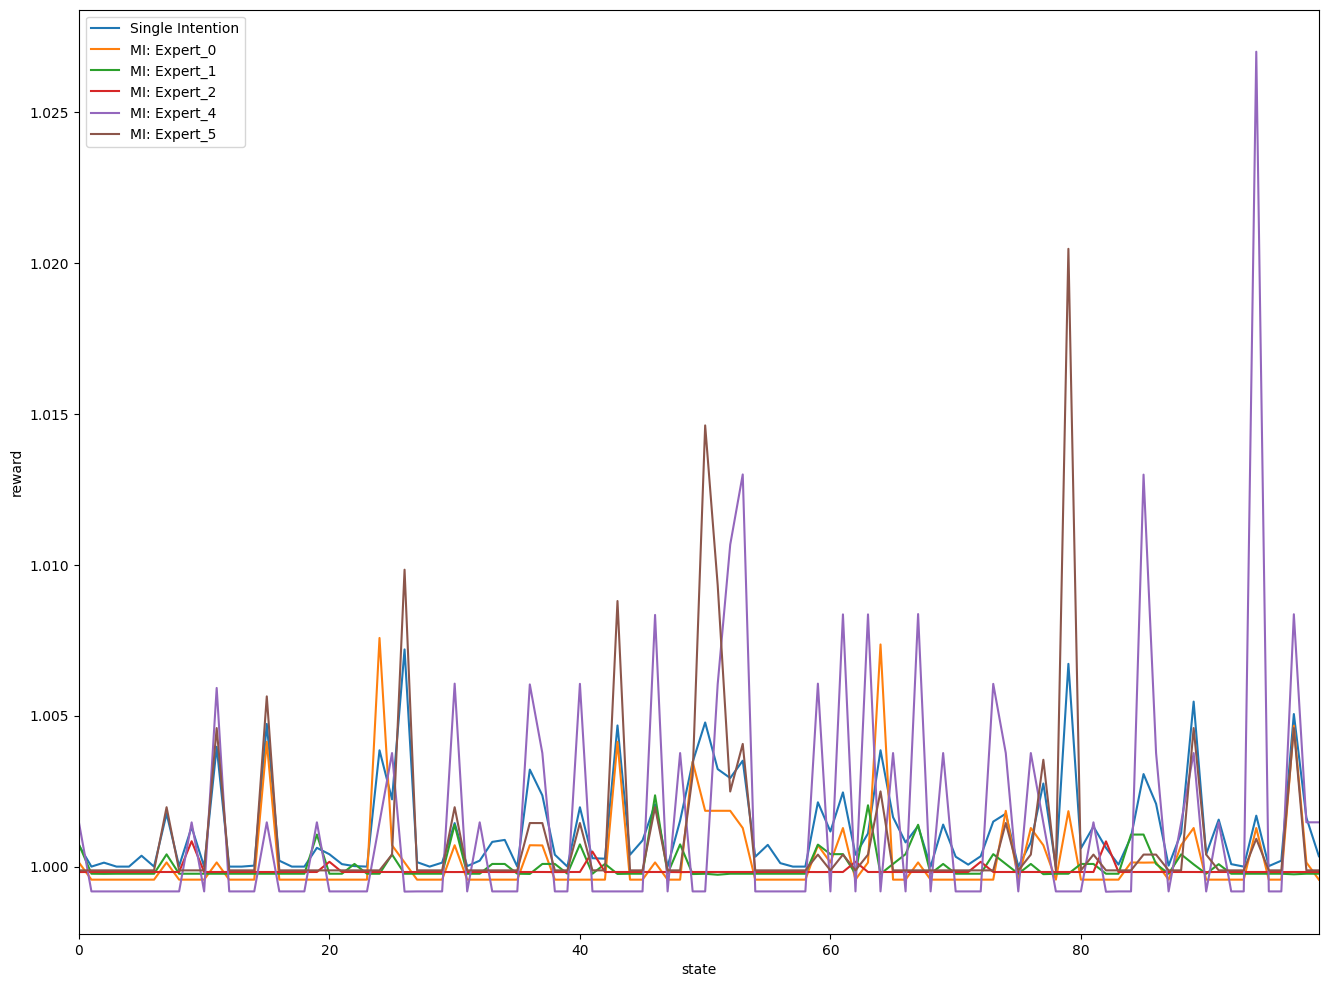

In [404]:
import matplotlib.pyplot as plt


x = np.arange(100)

fig, ax = plt.subplots(figsize=(16, 12))

# Plotting each dataset on the same axes with a label for the legend
ax.plot(x, reward_maxent_causal, label='Single Intention')
ax.plot(x, traj_models[0]['reward'], label='MI: Expert_0')
ax.plot(x, traj_models[1]['reward'], label='MI: Expert_1')
ax.plot(x, traj_models[2]['reward'], label='MI: Expert_2')
# ax.plot(x, traj_models[3]['reward'], label='MI: Expert_3')
ax.plot(x, traj_models[4]['reward'], label='MI: Expert_4')
ax.plot(x, traj_models[5]['reward'], label='MI: Expert_5')



# Adding the legend, which uses the labels specified in the plot commands
ax.legend()

# Setting the x-axis and y-axis labels
ax.set_xlabel('state')
ax.set_ylabel('reward')

# Setting the x-axis range from 0 to 99
ax.set_xlim([0, 99])

plt.show()

In [ ]:
max_iterations = 300
taus = list(trajectories_s.values())
epsilon = 0.005

In [394]:
# run iterations of EM 


for i in range(max_iterations): 
    # E-step

    prev_u = u 
    for i in range(n): 
        for k in range(K): 
            u[i][k] = (rho[k] * likelihood(taus[i], theta_mle[k])) / np.sum([rho[k_prime] * likelihood(taus[i], theta_mle[k_prime]) for k_prime in range(K)], axis=0)

    # M-step - update parameters 
    for k in range(K):
        rho[k] = np.sum([u[i][k] for i in range(n)]) / n 

    for k in range(K): 
        l = np.argmax([np.sum([u[i][k] * likelihood(taus[i], theta) for i in range(n)], axis=0) for theta in theta_mle])
        theta_mle[k] = theta_mle[l]

    # check if solution is epsilon-optimal and break 
    sol = 0 
    for i in range(n): 
        for k in range(k): 
            sol += np.abs(u[i][k] - prev_u[i][k])

    print(i)
    print(f"convergence: {sol / len(X)}")
    if sol / len(X) < epsilon: 
        break 


KeyboardInterrupt: 